# Molecular QTL workflow

In [1]:
%revisions -s -n 10

Revision,Author,Date,Message
45a37a2,Gao Wang,2018-07-09,Add outlier case analysis example notebook
7d85ad1,Gao Wang,2018-07-09,Separate DAP specific data processing from preprocessing step
889526b,Gao Wang,2018-07-09,Add linear regression follow up
a96907b,Gao Wang,2018-07-09,Improve data I/O for DAP
27f0167,Gao Wang,2018-07-09,Add DAP-g
85c5de0,Gao Wang,2018-07-08,More efficient implementation for CAVIAR follow up
6371e2b,Gao Wang,2018-07-08,follow up studies
53eff9f,Gao Wang,2018-07-06,Another run of 100Kb region instead of 1Mb
63045aa,Gao Wang,2018-07-05,Change figure layout
8c6e722,Gao Wang,2018-07-05,Add cluster configurations


## Data

Molecular QTL data from [Yang et al (2016) Science](http://eqtl.uchicago.edu/jointLCL/). Input are genotypes of ~100 YRI samples with their molecular QTL data measured in LCL.

- alternative splicing (AS) data is of the primary interest here.

### Genotypes

[Genotype data for YRI](http://eqtl.uchicago.edu/jointLCL/genotypesYRI.gen.txt.gz) is the conventional VCF format but has dosage for genotypes.

### Phenotypes

Phenotype data has format:

```
#Chr	start	end	ID	18486	18487	18488	18489	18498	18499
chr1	880180	880422	chr1:880180:880422:clu_15502	0.201694364955	0.665990212763	-1.21881815589	-0.342480185427	0.165404160483	-1.58524292941
```

The first 4 columns are genomic coordinates info. Others are molecular QTL in samples.

We analyze:

1. [Alternative splicing](http://eqtl.uchicago.edu/jointLCL/qqnorm_ASintron_RNAseqGeuvadis.txt)

## Analysis plan

- For each analysis unit (gene, or intron cluster for AS), get the 1MB up/down-stream variants in genotypes
- Remove top phenotype PC from phenotype data
- Fine-mapping using various methods. SuSiE for starters

## Workflow overview

In [3]:
!sos run 20180704_MolecularQTL_Workflow.ipynb -h

usage: sos run 20180704_MolecularQTL_Workflow.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  preprocess
  index_vcf
  SuSiE
  SuSiE_summary
  DAP
  CAVIAR_follow_up
  lm_follow_up

Global Workflow Options:
  --x-data . (as path)
                        X data, the genotype VCF file path
  --y-data . (as path)
                        Y data, the phenotype file paths
  --cwd  f'{y_data:d}_output'

                        Specify work directory
  --max-dist 1000000 (as int)
                        Maximum distance to site of
                        interest, eg. 1Mb up/downstream to
                        TSS for gene level QTL

Sections
  preprocess_1:         PCA

In [ ]:
[global]
# X data, the genotype VCF file path
parameter: x_data = path()
# Y data, the phenotype file paths
parameter: y_data = path()
# Specify work directory
parameter: cwd = f'{y_data:d}_output'
# Maximum distance to site of interest, eg. 1Mb up/downstream to TSS for gene level QTL
parameter: max_dist = 1000000
fail_if(not x_data.is_file(), msg = 'Please provide valid ``--x-data``!')
fail_if(not y_data.is_file(), msg = 'Please provide valid ``--y-data``!')
pop = 'YRI'

## Preprocessing analysis

The preprocessing pipeline can be executed locally, takes 3hrs on my 40-thread machine:

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb preprocess \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/AS/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz \
    --max-dist 100000 --num-pcs 3 -j 38
```

### Regressing out top PCs on phenotype

There may well be better approach to control for covariates etc, but [here](https://github.com/bmvdgeijn/WASP/blob/master/examples/example_data/H3K27ac/get_PCs.R) is workflow from the authors and was deemed sufficient. See their supplemental table of Yang et al 2016 for how many PC to use for each molecular QTLs.

Need to cope with missing phenotype data here. See `na.omit` function call in `prcomp` and `na.actions=na.exclude`.

In [ ]:
# PCA on phenotype and remove top PCs
[preprocess_1 (Remove top phenotype PC)]
# Num. PC to remove from phenotype
parameter: num_pcs = 3 # Table S2 of NIHMS835311-supplement-supplement.pdf
# column name patter for `grep` in R to select phenotype columns
# eg. "^NA[0-9]+" to extract sample names
parameter: colname_pattern = '^[0-9]+'
input: y_data
output: f"{cwd}/{_input:bn}.PC{num_pcs}.removed.gz"
R: expand = "${ }", workdir = cwd, stdout = f"{_output:n}.stdout"
    num_pcs = ${num_pcs}
    dat <- read.table(${_input:r}, header=T, comment.char='', check.names=F)
    phenotype.matrix <- dat[,5:ncol(dat)]
    # extract columns of interest
    phenotype.matrix <- phenotype.matrix[,grep("${colname_pattern}", colnames(phenotype.matrix), value = T)]
    # perform principal component analysis
    pca <- prcomp(na.omit(phenotype.matrix))
    # PCA summary
    print(summary(pca))
    cat("output", num_pcs, "PCs \n")
    # remove top PC from phenotype; takes a while
    cov_pcs <- pca$rotation[, 1:num_pcs]
    new.phenotype.matrix <- do.call(rbind, lapply(1:nrow(phenotype.matrix), function(i) residuals(lm(t(phenotype.matrix[i,]) ~ as.matrix(cov_pcs), na.action=na.exclude))))
    colnames(new.phenotype.matrix) <- colnames(phenotype.matrix)
    new.dat <- cbind(dat[,1:4], new.phenotype.matrix)
    colnames(new.dat)[1] <- 'chr'
    write.table(new.dat, gzfile(${_output:r}), sep="\t", quote=F, col.names=T, row.names=F)

### Extract per unit variables

In [ ]:
# this step provides VCF file index
[index_vcf: provides = '{filename}.gz.tbi']
depends: executable('tabix')
input: f"{filename}.gz"
bash: expand=True
   tabix -p vcf {_input}

# Extract cis-SNPs and make fine-mapping datasets
[preprocess_2 (Get per-unit dataset)]
depends: Py_Module('pysam'), Py_Module('pandas'), Py_Module('feather'), f"{x_data}.tbi"
chroms = [f'chr{x+1}' for x in range(22)]
input: for_each = 'chroms', concurrent = True
output: dynamic(glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/chr*/*.feather'))
python: workdir = cwd, expand = "${ }"
    def read_header(gzfile):
        import gzip
        with gzip.open(gzfile,'r') as f:
            for line in f:
                res = [x.decode() for x in line.split()]
                break
        return res

    chrom = "${_chroms}"
    phenotype_id = [f'${pop}_{x}' for x in read_header(${_input:r})[4:]]
    vcf_id = [f'${pop}_{x}' for x in read_header(${x_data:r})[9:]]
    from pathlib import Path
    import pysam
    tbx = pysam.TabixFile(${x_data:r})    
    import pandas as pd, numpy as np
    from feather import write_dataframe
    qts = pd.read_csv(${_input:r}, sep = '\t')
    qts = qts.loc[qts['chr'] == chrom]
    #
    import os, time, tempfile
    start_time = time.time()
    i = 0
    for site in sorted(set(qts['start'].tolist())):
        if(i % 100 == 0):
            print('[chrom %s percent completed] %.1f (%.1f sec elapsed)' % (chrom, (float(i+1)/qts.shape[0])*100, time.time() - start_time))        
        unit = qts.loc[qts['start'] == site]
        i += unit.shape[0]
        start = max(site - ${max_dist}, 0)
        end = site + ${max_dist}
        genotypes = np.array([row for row in tbx.fetch(chrom, start, end, parser=pysam.asTuple())])
        if len(genotypes) == 0:
            continue
        Y_data = unit.drop(["chr", "start", "end", "ID"], axis=1).T
        Y_data.columns = [x.replace(':', '_') for x in unit['ID']]
        Y_data.index = phenotype_id
        X_data = pd.DataFrame(genotypes[:,9:].T,
                              columns = ['_'.join(x) for x in genotypes[:,[2,0,1,3,4]]], 
                              index = vcf_id)
        merged = Y_data.join(X_data, how='inner').astype(np.float32)
        Path(f'${cwd}/${y_data:bnn}_${int(max_dist/1000)}Kb/{chrom}').mkdir(exist_ok=True, parents=True)
        basename = f'${cwd}/${y_data:bnn}_${int(max_dist/1000)}Kb/{chrom}/{chrom}_{site}_{max(unit["end"].tolist())}'
        # FIXME: this will be a large file because feather format is not yet compressed ... 
        # This is being discussed by the feather development group and hopefully compression will be supported in later 2018
        write_dataframe(merged, basename + '.feather')

### Summary statistics and PVE estimate

We want to estimate PVE from the top signal in each unit, to have an idea of how SuSiE prior variance should be configured. We can also compute summary statistics at this stage. We save only z-scores.

In [ ]:
# Summary statistics and PVE estimates
[preprocess_3 (PVE)]
depends: R_library('feather'), R_library('stephenslab/susieR')
input: group_by = 1, concurrent = True
output: f'{_input:n}.rds'
R: expand = '${ }'
    library(feather)
    dat = read_feather(${_input:r})
    n_y = length(grep("^chr", colnames(dat), value = T))
    Y = as.matrix(dat[,1:n_y,drop=F])
    X = as.matrix(dat[,(n_y+1):ncol(dat),drop=F])
    storage.mode(X) = 'double'
    storage.mode(Y) = 'double'
    bad = which(sapply(1:ncol(X), function(i) all(is.na(X[,i]))))
    if (length(bad) >= 1) {
      snps = colnames(X)[-bad]
      X = X[,-bad,drop=F]
    } else {
      snps = colnames(X)
    }
    res = list()
    for (r in 1:ncol(Y)) {
      keep_rows = which(!is.na(Y[,r]))
      x = X[keep_rows,,drop=F]
      y = Y[,r][keep_rows]
      reg = susieR:::univariate_regression(x,y)
      z_score = reg$betahat/reg$sebetahat
      names(z_score) = snps
      top_idx = which.max(abs(z_score))
      pve = var(x[,top_idx] * reg$betahat[top_idx]) / var(y)
      res[[r]] = list(X=x, y=y, z_score=z_score, pve=pve, uname=colnames(Y)[[r]])
    }
    saveRDS(res, ${_output:r})
_input.zap()

## Finemapping with SuSiE

This step takes 3hrs on my 40-thread machine: 

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb SuSiE \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/AS/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz \
    --max-dist 100000 -j 38
```

and we only plot the ones SuSiE reports at least 1 CS: 

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb SuSiE_summary \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/AS/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz \
    --max-dist 100000 -j 38
```

In [ ]:
# Run SuSiE
[SuSiE (SuSiE analysis)]
depends: R_library('susieR')
# SuSiE parameter: L
parameter: maxL = 5
# SuSiE parameter: prior variance; set to 0 to use PVE estimates
parameter: prior_var = 0
input: glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/chr*/*.rds'), group_by = 1, concurrent = True
output: dynamic(glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/SuSiE_CS_*/*.rds'))
#task: trunk_workers = 1, queue = 'midway2_head', walltime = '10m', trunk_size = 1000, mem = '2G', cores = 1, workdir = cwd, concurrent = True
R: expand = "${ }"
    library(susieR)
    set.seed(1)
    dat = readRDS(${_input:r})
    for (r in length(dat)) {
      fitted = susie(dat[[r]]$X, dat[[r]]$y,
               L=${maxL},
               estimate_residual_variance=TRUE, 
               prior_variance=${prior_var if prior_var > 0 else "dat[[r]]$pve"},
               tol=1e-3)
      sets = susie_get_CS(fitted,
                    coverage = 0.95,
                    X = dat[[r]]$X, 
                    min_abs_corr = 0.4)
      pip = susie_get_PIP(fitted, sets$cs_index)
      dirname = paste0('${cwd}/${y_data:bnn}_${int(max_dist/1000)}Kb/SuSiE_CS_', length(sets$cs_index), '/')
      system(paste("mkdir -p", dirname))
      if (length(sets$cs_index) > 0) {
          saveRDS(list(input=${_input:r},idx=r,fitted=fitted,sets=sets,pip=pip), paste0(dirname, dat[[r]]$uname, '.rds'))
      } else {
          saveRDS(list(input=${_input:r},idx=r,fitted=fitted), paste0(dirname, dat[[r]]$uname, '.rds'))       
      }
    }

In [ ]:
# Make SuSiE result plots for significant results
[SuSiE_summary (plot SuSiE results)]
input: glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/SuSiE_CS_[1-9]/*.rds'), group_by = 1, concurrent = True
output: f'{_input:n}.png'
R: expand = '${ }', stdout = f'{_output:n}.log'
    library(susieR)
    dat = readRDS(${_input:r})
    z_score = readRDS(dat$input)[[dat$idx]]$z_score
    b = rep(0,length(z_score))
    b[which.max(abs(z_score))] = 1
    png(${_output:r}, 12, 6, units = 'in', res = 500)
    par(mfrow=c(1,2))
    susie_pplot(z_score, dtype='z', b=b)
    susie_pplot(dat$pip, fitted=dat$fitted, dtype='PIP', b=b) 
    dev.off()

## Finemapping with DAP

I made this for Kevin's analysis:

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb preprocess+DAP \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/m6A/fastqtl_m6A_merged_peaks_IPcounts_YangVCF.txt.gz \
    --max-dist 100000 --num-pcs 7 -j 38 \
    -b ~/GIT/github/mvarbvs/dsc/modules/linux/
sos run analysis/20180704_MolecularQTL_Workflow.ipynb preprocess+DAP \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/ribo/fastqtl_ribo_normExpr_YangVCF.txt.gz \
    --max-dist 100000 --num-pcs 2 -j 38 \
    -b ~/GIT/github/mvarbvs/dsc/modules/linux/
sos run analysis/20180704_MolecularQTL_Workflow.ipynb DAP \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/AS/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz \
    --max-dist 100000 --num-pcs 3 -j 38 \
    -b ~/GIT/github/mvarbvs/dsc/modules/linux/
```

In [ ]:
# Convert to DAP format
[DAP_1 (convert to DAP data format)]
input: glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/chr*/*.rds'), group_by = 1, concurrent = True
output: dynamic(glob.glob(f'{_input:dd}/DAP-g/*.DAP.gz'))
R: expand = '${ }'
    dat = readRDS(${_input:r})
    dirname = paste0(${_input:ddr}, '/DAP-g/')
    system(paste('mkdir -p', dirname))
    for (r in 1:length(dat)) {
      pheno = c('pheno', '${y_data:bnn}', dat[[r]]$uname, dat[[r]]$y)
      geno = cbind(rep('geno', ncol(dat[[r]]$X)), colnames(dat[[r]]$X), rep(dat[[r]]$uname, ncol(dat[[r]]$X)), t(dat[[r]]$X))
      write.table(rbind(pheno, geno), gzfile(paste0(dirname, dat[[r]]$uname, '.DAP.gz')), quote=F,col.names=F,row.names=F)
  }

In [ ]:
# Run DAP-g
[DAP_2 (run DAP-g)]
depends: Py_Module('dsc'), Py_Module('rpy2')
input: group_by = 1, concurrent = True
output: f'{_input:n}.output.rds'
bash: expand = True, stderr = f'{_output:n}.log'
    dap-g -d <(zcat {_input}) -o {_output:n} -t 1 --all
    exit 0

python: expand = '${ }'
    import pandas as pd
    def extract_dap_output(fn):
        out = [x.strip().split() for x in open(fn).readlines()]
        pips = []
        clusters = []
        still_pip = True
        for line in out:
            if len(line) == 0:
                continue
            if len(line) > 2 and line[2] == 'cluster_pip':
                still_pip = False
                continue
            if still_pip and (not line[0].startswith('((')):
                continue
            if still_pip:
                pips.append([line[1], float(line[2]), float(line[3]), int(line[4])])
            else:
                clusters.append([len(clusters) + 1, float(line[2]), float(line[3])])
        pips = pd.DataFrame(pips, columns = ['snp', 'snp_prob', 'snp_log10bf', 'cluster'])
        clusters = pd.DataFrame(clusters, columns = ['cluster', 'cluster_prob', 'cluster_avg_r2'])
        clusters = pd.merge(clusters, pips.groupby(['cluster'])['snp'].apply(','.join).reset_index(), on = 'cluster')
        return {'snp': pips, 'set': clusters}

    from dsc.dsc_io import save_rds
    save_rds(extract_dap_output(${_output:nr}), ${_output:r})
_input.zap()

## Follow-up: verify with CAVIAR

I found ~1600 splicing QTLs. Only about 150 reports more than 1 CS. But most of these 2+ QTLs are from a scenarios that there seemingly is one signal cluster from the z-score but SuSiE decides to use two CS to capture that cluster.

Another observation from the SuSiE analysis is that in a number of cases the smallest p-value is not picked up.

To verify how many signals are in there when there is seemingly one cluster visually, we run CAVIAR for those data. Input for CAVIAR are z-scores and LD matrices.

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb CAVIAR_follow_up \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/AS/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz \
    --max-dist 100000 -b ~/GIT/github/mvarbvs/dsc/modules/linux/
```

In [ ]:
# Run CAVIAR on SuSiE results of interest
[CAVIAR_follow_up_1]
parameter: caviar_args = '-c 2'
input: glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/SuSiE_CS_[2-9]/*.rds'), group_by = 1, concurrent = True
output: f'{_input:dd}/CAVIAR_follow_up/{_input:bn}.CAVIAR.rds'
R: expand = '${ }', stdout = False, stderr = False
    library('dplyr')
    library('magrittr')
    #' CAVIAR I/O
    write_caviar_sumstats <- function(z, prefix) {
      cfg = list(z=paste0(prefix,".z"),
                 set=paste0(prefix,"_set"),
                 post=paste0(prefix,"_post"),
                 log=paste0(prefix,".log"))
      write.table(z,cfg$z,quote=F,col.names=F)
      return(cfg)
    }

    #' Run CAVIAR
    #' https://github.com/fhormoz/caviar
    run_caviar <- function(z, X, args = "", prefix="data")
    {
      cfg = write_caviar_sumstats(z, prefix)
      LD_file = paste0(prefix, '.ld')
      write.table(cor(X), LD_file,quote=F,col.names=F,row.names=F)
      cmd = paste("CAVIAR", "-z", cfg$z, "-l", LD_file, "-o", prefix, args)
      dscrutils::run_cmd(cmd)
      if(!all(file.exists(cfg$post, cfg$set, cfg$log))) {
          stop("Cannot find one of the post, set, and log files")
      }

      log <- readLines(cfg$log)

      # read output tables
      snp <- read.delim(cfg$post)
      stopifnot(ncol(snp) == 3)
      names(snp) <- c("snp", "snp_prob_set", "snp_prob")
      snp$snp <- as.character(snp$snp)
      snp <- rank_snp(snp)

      # `set` of snps
      set <- readLines(cfg$set)
      set_ordered <- left_join(data_frame(snp = set), snp, by = "snp") %>% 
        arrange(rank) %$% snp
      return(list(snp=snp, set=set_ordered))
    }

    rank_snp <- function(snp) {
      snp <- arrange(snp, -snp_prob) %>%
        mutate(
            rank = seq(1, n()),
            snp_prob_cumsum = cumsum(snp_prob) / sum(snp_prob)) %>%
        select(rank, snp, snp_prob, snp_prob_cumsum, snp_prob_set)
      return(snp)    
    }
    #
    susie_res = readRDS(${_input:r})
    dat = readRDS(susie_res$input)[[susie_res$idx]]
    # CAVIAR CODE
    caviar = run_caviar(dat$z_score, dat$X, args = '${caviar_args}', prefix = paste0(${_output:nr}, '.tmp'))
    saveRDS(list(susie_res=${_input:r}, pip=caviar$snp,sets=caviar$set_ordered), ${_output:r})
    system('rm -f ${_output:n}.tmp_*')

In [ ]:
# Plot CAVIAR vs SuSiE results
[CAVIAR_follow_up_2]
input: group_by = 1, concurrent = True
output: f'{_input:n}.png'
R: expand = '${ }'
    library(susieR)
    caviar_res = readRDS(${_input:r})
    susie_res = readRDS(caviar_res$susie_res)
    z_score = readRDS(susie_res$input)[[susie_res$idx]]$z_score
    b = rep(0,length(z_score))
    b[which.max(abs(z_score))] = 1
    # re-organize caviar
    caviar_pip = caviar_res$pip$snp_prob
    names(caviar_pip) = caviar_res$pip$snp
    caviar_pip = caviar_pip[names(z_score)]
    png(${_output:r}, 8, 8, units = 'in', res = 500)
    par(mfrow=c(2,2),mar=c(3,3,3,3))
    susie_pplot(z_score, dtype='z', b=b)
    susie_pplot(susie_res$pip, dtype='PIP', b=b)
    plot(susie_res$pip, caviar_pip, pch = 16, xlab='SuSiE_PIP', ylab = 'CAVIAR_PIP')
    abline(a=0,b=1,col='red')
    susie_pplot(caviar_pip, dtype='PIP', b=b)
    dev.off()

## Follow-up: verify with multiple regression

For SuSiE 1 or more CS results we can construct a multiple regression model using top PIP from each CS, then get the residual, and regress it with the SNP that has top z-score, to see if the effect on the top SNP disappears.

```
sos run analysis/20180704_MolecularQTL_Workflow.ipynb lm_follow_up \
    --x-data ~/GIT/LargeFiles/AS/genotypesYRI.gen.txt.gz \
    --y-data ~/GIT/LargeFiles/AS/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF.txt.gz \
    --max-dist 100000
```

In [ ]:
# Run linear regression conditional on SuSiE CS
[lm_follow_up_1]
input: glob.glob(f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/SuSiE_CS_[1-9]/*.rds'), group_by = 1, concurrent = True
output: f'{_input:dd}/lm_follow_up/{_input:bn}.lm.rds'
R: expand = '${ }'
  # Load data
  susie_res = readRDS(${_input:r})
  dat = readRDS(susie_res$input)[[susie_res$idx]]
  # lm code
  top_susie = sapply(1:length(susie_res$sets$cs), function(i) susie_res$sets$cs[[i]][which.max(susie_res$pip[susie_res$sets$cs[[i]]])])
  residual = .lm.fit(dat$X[,top_susie,drop=F], dat$y)$residuals
  top_z = which.max(dat$z_score)
  top_pval = summary(lm(residual~dat$X[,top_z]))$coef[2,4]
  names(top_pval) = names(dat$z_score)[top_z]
  top_pip = susie_res$pip[top_susie]
  names(top_pip) = names(dat$z_score)[top_susie]
  saveRDS(list(top_pip=top_pip, top_pval=top_pval), ${_output:r})

In [ ]:
# Summarize the outcome
[lm_follow_up_2]
output: f'{cwd}/{y_data:bnn}_{int(max_dist/1000)}Kb/lm_follow_up/top_cond_pval.rds'
R: expand = '${ }'
    input = c(${_input:r,})
    res = sapply(1:length(input), function(i) readRDS(input[i])$top_pval)
    saveRDS(res, ${_output:r})

Here are the top z-scores that remains significant after removing them from linear regression model:

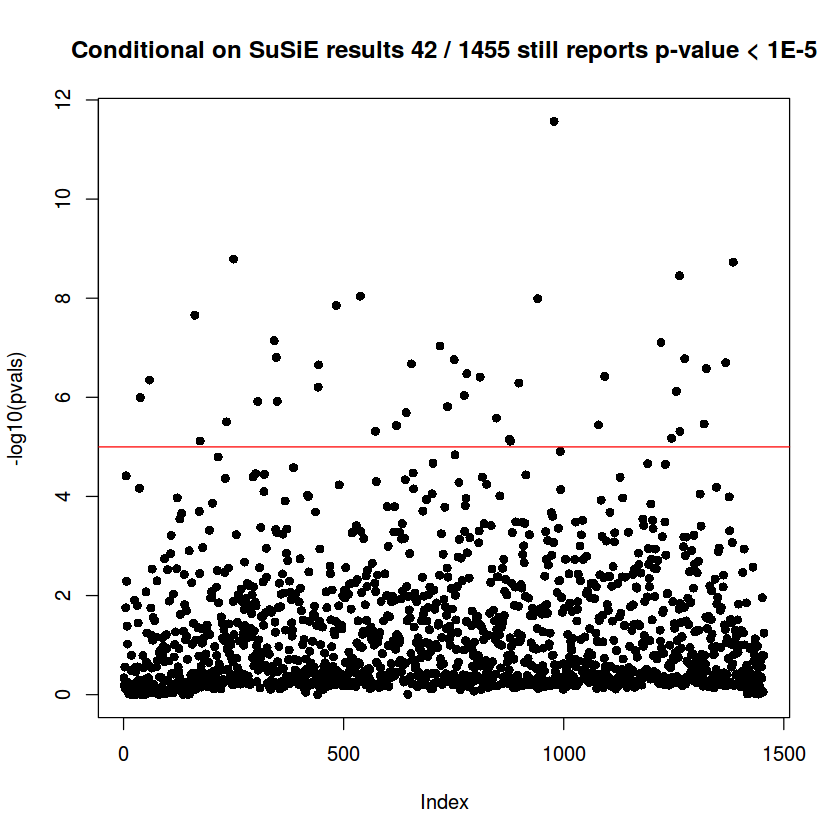

In [20]:
fn = '~/Documents/GIT/LargeFiles/AS_output/fastqtl_qqnorm_ASintron_RNAseqGeuvadis_YangVCF_100Kb/lm_follow_up/top_cond_pval.rds'
pvals = readRDS(fn)
plot(-log10(pvals),pch=16,main = paste("Conditional on SuSiE results", sum(pvals<1E-5), "/", length(pvals), "still reports p-value < 1E-5"))
abline(a=5,b=0,col='red')